# Convolutional Neural Networks in TensorFlow

Welcome to another tutorial part! In this notebook, we will:

- Implement helper functions that we will use when implementing a TensorFlow model
- Implement a fully functioning ConvNet using TensorFlow 

**After this tutorial we will be able to:**

- Build and train a ConvNet in TensorFlow for a classification problem 


## TensorFlow model:


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf

In [2]:
ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 2

In [3]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prepare_data(images):
    m = len(images)
    X = np.zeros((m, ROWS, COLS, CHANNELS), dtype=np.uint8)
    y = np.zeros((1, m), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = read_image(image_file)
        if 'dog' in image_file.lower():
            y[0, i] = 1
        elif 'cat' in image_file.lower():
            y[0, i] = 0
    return X, y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
TRAIN_DIR = 'Train_data/'
TEST_DIR = 'Test_data/'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_set_x, train_set_y = prepare_data(train_images)
test_set_x, test_set_y = prepare_data(test_images)

X_train = train_set_x/255
X_test = test_set_x/255

Y_train = convert_to_one_hot(train_set_y, CLASSES).T
Y_test = convert_to_one_hot(test_set_y, CLASSES).T

In [5]:
print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

number of training examples = 6002
number of test examples = 1000
X_train shape: (6002, 64, 64, 3)
Y_train shape: (6002, 2)
X_test shape: (1000, 64, 64, 3)
Y_test shape: (1000, 2)


## 1 - Create placeholders

TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session:

**Arguments**:<br>
    n_H0 - scalar, height of an input image<br>
    n_W0 - scalar, width of an input image<br>
    n_C0 - scalar, number of channels of the input<br>
    n_y - scalar, number of classes<br>

**Returns**:<br>
    X - placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"<br>
    Y - placeholder for the input labels, of shape [None, n_y] and dtype "float"<br>

In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0), name="X")
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name="Y")
    
    return X, Y

In [7]:
X, Y = create_placeholders(ROWS, COLS, CHANNELS, CLASSES)
print ("X = ", X)
print ("Y = ", Y)

X =  Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y =  Tensor("Y:0", shape=(?, 2), dtype=float32)


## 2 - Initialize parameters

We will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer()`. 

The dimensions for each group of filters will be: [weight, height, channels, filters]

In [8]:
def initialize_parameters():
    
    W1 = tf.get_variable("W1", [4, 4, 3, 32], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 32, 32], initializer = tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1,
                  "W2": W2}
   
    return parameters

In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = ", parameters["W1"].eval()[1,1,1])
    print("W2 = ", parameters["W2"].eval()[1,1,1])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 =  [ 0.04705196  0.04266799 -0.08361002  0.04801854 -0.03617621 -0.05653762
 -0.06668487 -0.03004657  0.0323144   0.07576969  0.0044159   0.08514661
  0.0271151   0.07883001 -0.07369583  0.04216484 -0.03514422 -0.10011511
  0.0080948   0.00930988 -0.08420315  0.05472993 -0.04239055  0.05840429
 -0.07025893 -0.05593808  0.04091822  0.02706557  0.09153362 -0.04630034
 -0.066306   -0.01621507]
W2 =  [ 0.01274848  0.13589354 -0.01097573  0.02410334 -0.14818062 -0.11319079
  0.05544482  0.07326157 -0.13342384 -0.14699265 -0.07028151 -0.12421544
  0.04285373  0.06071918  0.116403   -0.14559078  0.1505435  -0.04966621
  0.04467162  0.1411993  -0.06348611  0.06453162  0.13407396 -0.024422

## 3 - Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for us.

- **tf.nn.conv2d()**
- **tf.nn.max_pool()**
- **tf.nn.relu()**
- **tf.contrib.layers.flatten()**
- **tf.contrib.layers.fully_connected()**


So we will implement the `forward_propagation` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`.  

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer.

**Arguments**:<br>
    X - input dataset placeholder, of shape (input size, number of examples)<br>
    parameters - python dictionary containing our parameters "W1", "W2"<br>

**Returns**:<br>
    Z3 - the output of the last LINEAR unit<br>

In [10]:
def forward_propagation(X, parameters):
    # Retrieving the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    print("Z1 shape", Z1.shape)
    
    # RELU
    A1 = tf.nn.relu(Z1)
    print("A1 shape", A1.shape)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    print("P1 shape", P1.shape)
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    print("Z2 shape", Z2.shape)
    
    # RELU
    A2 = tf.nn.relu(Z2)
    print("A2 shape", A2.shape)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    print("P2 shape", P2.shape)
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    print("P2 FLATTEN shape", P2.shape)
    
    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    # 2 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, CLASSES, activation_fn=None)
    print("Z3 shape", Z3.shape)

    return Z3

In [13]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(ROWS, COLS, CHANNELS, CLASSES)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,CLASSES)})
    print("Z3 =", a)
    print("Z3 shape =", a.shape)

Z1 shape (?, 64, 64, 32)
A1 shape (?, 64, 64, 32)
P1 shape (?, 8, 8, 32)
Z2 shape (?, 8, 8, 32)
A2 shape (?, 8, 8, 32)
P2 shape (?, 2, 2, 32)
P2 FLATTEN shape (?, 128)
Z3 shape (?, 2)
Z3 = [[-2.033988   -0.43849364]
 [-2.1268568  -0.6470382 ]]
Z3 shape = (2, 2)


## 3 - Compute cost

We will implement the compute cost function:

**Arguments**:<br>
    Z3 - output of forward propagation (output of the last LINEAR unit), of shape (CLASSES, number of examples)<br>
    Y - "true" labels vector placeholder, same shape as Z3<br>

**Returns**:<br>
    cost - Tensor of the cost function<br>

In [14]:
def compute_cost(Z3, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [16]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(ROWS, COLS, CHANNELS, CLASSES)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,CLASSES)})
    print("cost = ", a)

Z1 shape (?, 64, 64, 32)
A1 shape (?, 64, 64, 32)
P1 shape (?, 8, 8, 32)
Z2 shape (?, 8, 8, 32)
A2 shape (?, 8, 8, 32)
P2 shape (?, 2, 2, 32)
P2 FLATTEN shape (?, 128)
Z3 shape (?, 2)
cost =  -1.6325974


## 4 - Mini-Batch Gradient descent

I copied mini-batches function from my last Deep Network TensorFlow tutorial, and adopted it to new data-set shape:

**Arguments**:<br>
X - input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)<br>
Y - true "label" vector (containing 0 if cat, 1 if dog), of shape (1, number of examples) (m, n_y)<br>
mini_batch_size - size of the mini-batches, integer<br>

**Returns**:<br>
mini_batches - list of synchronous (mini_batch_X, mini_batch_Y)<br>

In [19]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    # number of training examples
    m = X.shape[0]                  
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 5 Model 

Finally we will merge the helper functions we implemented above to build a model. 

So we'll implement a three-layer ConvNet in Tensorflow: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED.

**Arguments**:<br>
    X_train - training set, of shape (None, ROWS, COLS, CHANNELS)<br>
    Y_train - test set, of shape (None, n_y = CLASSES)<br>
    X_test - training set, of shape (None, ROWS, COLS, CHANNELS)<br>
    Y_test - test set, of shape (None, n_y = CLASSES)<br>
    learning_rate - learning rate of the optimization<br>
    num_epochs - number of epochs of the optimization loop<br>
    minibatch_size - size of a minibatch<br>
    print_cost - True to print the cost every 100 epochs<br>

**Returns**:<br>
    train_accuracy - real number, accuracy on the train set (X_train)<br>
    test_accuracy - real number, testing accuracy on the test set (X_test)<br>
    parameters - parameters learnt by the model. They can then be used to predict.<br>

In [21]:
tf.reset_default_graph()
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 200, minibatch_size = 64, print_cost = True):

    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1] 
    
    # To keep track of the cost
    costs = []                                        
    
    # Createing Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initializing parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Building the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Adding cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Defining the tensorflow optimizer. Using an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initializing all the variables globally
    init = tf.global_variables_initializer()
     
    # Starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Runing the initialization
        sess.run(init)
        
        # Doing the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            # number of minibatches of size minibatch_size in the train set
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")     
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        # Saving our trained model
        saver = tf.train.Saver()
        tf.add_to_collection('predict_op', predict_op)
        saver.save(sess, './my-CNN-model')        
                
        return train_accuracy, test_accuracy, parameters

Run the following cell to train your model for 200 epochs:

Z1 shape (?, 64, 64, 32)
A1 shape (?, 64, 64, 32)
P1 shape (?, 8, 8, 32)
Z2 shape (?, 8, 8, 32)
A2 shape (?, 8, 8, 32)
P2 shape (?, 2, 2, 32)
P2 FLATTEN shape (?, 128)
Z3 shape (?, 2)
Cost after epoch 0: 0.701049
Cost after epoch 5: 0.580966
Cost after epoch 10: 0.525494
Cost after epoch 15: 0.509302
Cost after epoch 20: 0.485024
Cost after epoch 25: 0.459250
Cost after epoch 30: 0.440039
Cost after epoch 35: 0.425924
Cost after epoch 40: 0.396368
Cost after epoch 45: 0.386514
Cost after epoch 50: 0.371097
Cost after epoch 55: 0.354108
Cost after epoch 60: 0.356975
Cost after epoch 65: 0.337785
Cost after epoch 70: 0.349771
Cost after epoch 75: 0.333455
Cost after epoch 80: 0.319151
Cost after epoch 85: 0.323412
Cost after epoch 90: 0.302988
Cost after epoch 95: 0.300407
Cost after epoch 100: 0.289466
Cost after epoch 105: 0.291612
Cost after epoch 110: 0.267726
Cost after epoch 115: 0.288019
Cost after epoch 120: 0.297686
Cost after epoch 125: 0.265527
Cost after epoch 130: 0.271859
C

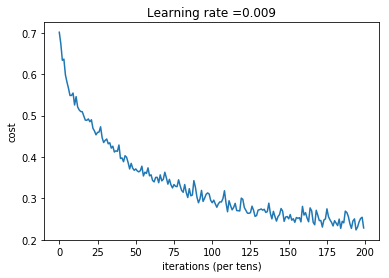

Parameters have been trained!
Train Accuracy: 0.92952347
Test Accuracy: 0.703


In [22]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

## 6 - Test with your own image:

When we save the variables, it creates a .meta file. This file contains the graph structure. Therefore, we can import the meta graph `using tf.train.import_meta_graph()` and restore the values of the graph. Let's import the graph and see all tensors in the graph:

In [23]:
# delete the current graph
tf.reset_default_graph()

# import the graph from the file
imported_graph = tf.train.import_meta_graph('my-CNN-model.meta')

# list all the tensors in the graph
for tensor in tf.get_default_graph().get_operations():
    print (tensor.name)

X
Y
W1/Initializer/random_uniform/shape
W1/Initializer/random_uniform/min
W1/Initializer/random_uniform/max
W1/Initializer/random_uniform/RandomUniform
W1/Initializer/random_uniform/sub
W1/Initializer/random_uniform/mul
W1/Initializer/random_uniform
W1
W1/Assign
W1/read
W2/Initializer/random_uniform/shape
W2/Initializer/random_uniform/min
W2/Initializer/random_uniform/max
W2/Initializer/random_uniform/RandomUniform
W2/Initializer/random_uniform/sub
W2/Initializer/random_uniform/mul
W2/Initializer/random_uniform
W2
W2/Assign
W2/read
Conv2D
Relu
MaxPool
Conv2D_1
Relu_1
MaxPool_1
Flatten/flatten/Shape
Flatten/flatten/strided_slice/stack
Flatten/flatten/strided_slice/stack_1
Flatten/flatten/strided_slice/stack_2
Flatten/flatten/strided_slice
Flatten/flatten/Reshape/shape/1
Flatten/flatten/Reshape/shape
Flatten/flatten/Reshape
fully_connected/weights/Initializer/random_uniform/shape
fully_connected/weights/Initializer/random_uniform/min
fully_connected/weights/Initializer/random_uniform/max

We can now take a picture of our cat or dog and see the output of our model. To do that:

In [26]:
test_image = "cat.jpg"
#test_image = "dog.jpg"
my_image = read_image(test_image).reshape(1, ROWS, COLS, CHANNELS)
X = my_image / 255.
#print(X.shape)

checkpoint_path = 'my-CNN-model'
tf.reset_default_graph()

with tf.Session() as sess:

    ## Load the entire model previuosly saved in a checkpoint
    print("Load the model from path", checkpoint_path)
    the_Saver = tf.train.import_meta_graph(checkpoint_path + '.meta')
    the_Saver.restore(sess, checkpoint_path)

    ## Identify the predictor of the Tensorflow graph
    predict_op = tf.get_collection('predict_op')[0]

    ## Identify the restored Tensorflow graph
    dataFlowGraph = tf.get_default_graph()

    ## Identify the input placeholder to feed the images into as defined in the model 
    x = dataFlowGraph.get_tensor_by_name("X:0")

    ## Predict the image category
    prediction = sess.run(predict_op, feed_dict = {x: X})

    print("\nThe predicted image class is:", np.squeeze(prediction))

Load the model from path my-CNN-model
INFO:tensorflow:Restoring parameters from my-CNN-model

The predicted image class is: 1


Congratulations! We have finised the tutorial and built a model that recognizes Cat versus Dog. If you wish, feel free to play around with this dataset further. You can actually improve its accuracy by spending more time tuning the hyperparameters. 

Once again, nice work ! 
In next tutorial we'll start building CNN in Keras !